In [215]:
import warnings
warnings.filterwarnings('ignore')
import gzip
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import folium
import shapely
import os
geopy.geocoders.options.default_user_agent = "test_user"

In [216]:
#reimport from xls for Clustering
import pandas as pd
LondonCheckinsClf = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClf.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


# <font color='red'>Unsupervised Learning -> K-means and Diff Priv K-means </font>

## Average out the Lat & Long by Suburb to get idea of potential clusters

Using this k-anonymity article as an approach:
https://medium.com/brillio-data-science/a-brief-overview-of-k-anonymity-using-clustering-in-python-84203012bdea

In [217]:
LondonCheckinsCounts = pd.DataFrame(LondonCheckinsClf.groupby('city_district')['city_district'].count().reset_index(name = "Count"))
LondonCheckinsCounts

,city_district,Count
0,Brigstock Road,5
1,Bromley Common,1
2,Coney Hall,1
3,Elmers End,7
4,Green Street Green,1
5,High Street,1
6,Locksbottom,2
7,London Borough of Bexley,39
8,London Borough of Bromley,552
9,London Borough of Croydon,513


In [218]:
LondonCheckins_avg1 = LondonCheckinsClf.groupby(['city_district']).agg({'latitude':['mean','median']})
LondonCheckins_avg2 = LondonCheckinsClf.groupby(['city_district']).agg({'longitude':['mean','median']})
LondonCheckingsSummary = pd.merge(LondonCheckins_avg1, LondonCheckins_avg2, on='city_district', how='outer')
LondonCheckingsSummary =pd.merge(LondonCheckingsSummary, LondonCheckinsCounts, on='city_district', how='outer')
LondonCheckingsSummary

,city_district,"(latitude, mean)","(latitude, median)","(longitude, mean)","(longitude, median)",Count
0,Brigstock Road,51.398953,51.398976,-0.098746,-0.098743,5
1,Bromley Common,51.376099,51.376099,0.042383,0.042383,1
2,Coney Hall,51.373891,51.373891,-0.005108,-0.005108,1
3,Elmers End,51.397779,51.398389,-0.047696,-0.049503,7
4,Green Street Green,51.354530,51.354530,0.093475,0.093475,1
5,High Street,51.397793,51.397793,-0.093155,-0.093155,1
6,Locksbottom,51.369063,51.369063,0.057840,0.057840,2
7,London Borough of Bexley,51.429288,51.426544,0.099133,0.101237,39
8,London Borough of Bromley,51.397532,51.404219,0.029083,0.017738,552
9,London Borough of Croydon,51.377354,51.375049,-0.098554,-0.097730,513


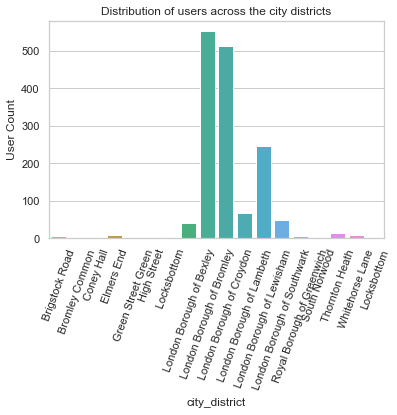

In [219]:
import seaborn as sns
sns.set(style="whitegrid")
sns.barplot(data=LondonCheckingsSummary, x='city_district', y='Count')

# Labels
plt.xticks(rotation=70)
plt.title('Distribution of users across the city districts')
plt.xlabel('city_district')
plt.ylabel('User Count')

plt.show()

In [220]:
# get london stations from https://www.doogal.co.uk/london_stations.php and put in CSV
LondonStations = pd.read_csv("C:\\Users\\Basia\Downloads\\LondonTrainStations.csv") 
FilterLatsStations = LondonStations[(LondonStations['Latitude']>= 51.345375) & (LondonStations['Latitude']<= 51.444771)]
LondonStations = FilterLatsStations[(FilterLatsStations['Longitude']>= -0.123386) & (FilterLatsStations['Longitude']<=0.112477)]
LondonStations.head(1000)

,Station,Postcode,Latitude,Longitude
5,Addington Village,CR0 5AR,51.356239,-0.032665
6,Addiscombe,CR0 7AA,51.379808,-0.073213
15,Anerley,SE20 8PY,51.412517,-0.065137
19,Arena,SE25 4RY,51.391523,-0.058319
22,Avenue Road,BR3 4NJ,51.406798,-0.049447
...,...,...,...,...
609,West Croydon,CR0 2TA,51.378552,-0.102034
611,West Dulwich,SE21 8HN,51.440912,-0.090673
620,West Norwood,SE27 0HS,51.431241,-0.103189
624,West Wickham,BR4 0PY,51.381284,-0.014576


## Remove columns not needed for unsupervised learning

In [221]:
#reimport from xls for Clustering
import pandas as pd
LondonCheckinsClf = pd.read_excel (r'LondonCheckinsBusiness.xlsx')
LondonCheckinsClf.head(2)

,user,check_in_time,latitude,longitude,location_id,checkin_Date,checkin_time,checkin_year,checkin_month,checkin_day,checkin_hour,checkin_weekday,Address,Location,city_district
0,72,2010-04-18T07:04:21Z,51.442041,-0.004450,808780,2010-04-18,07:04:21,2010,4,18,7,Sunday,"Sandhurst Road, Catford South, London Borough ...",Sandhurst Road,London Borough of Lewisham
1,72,2010-04-16T16:33:11Z,51.375217,-0.103929,587260,2010-04-16,16:33:11,2010,4,16,16,Friday,"Centrale, Tamworth Road, Broad Green, London B...",Centrale,London Borough of Croydon


LondonCheckinsClf.dtypes

** removing columns for Clustering including user because not trying to predict here **

In [222]:

LondonCheckinsClf = LondonCheckinsClf.drop(['location_id','check_in_time','checkin_Date','user',
                                            'checkin_time','checkin_year','checkin_day','Address'
                                            ,'checkin_hour','checkin_weekday','checkin_month','city_district','Location'
                                            #'latitude','longitude'
                                           ], axis=1)
LondonCheckinsClf

,latitude,longitude
0,51.442041,-0.004450
1,51.375217,-0.103929
2,51.375217,-0.103929
3,51.374846,-0.103378
4,51.379984,-0.101773
...,...,...
1508,51.411516,-0.121704
1509,51.381669,-0.114972
1510,51.404219,0.015095
1511,51.400061,0.017416


# First use KMeans clustering on Non Privatised Data

In [223]:
#libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_samples
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using this k-anonymity article as an approach:
https://medium.com/brillio-data-science/a-brief-overview-of-k-anonymity-using-clustering-in-python-84203012bdea

1. first see if i can group the data lat and long on average. By London Burrough it shows that there shouldn't be less than 39 users per cluster in this dataset

Text(0, 0.5, 'Inertia')

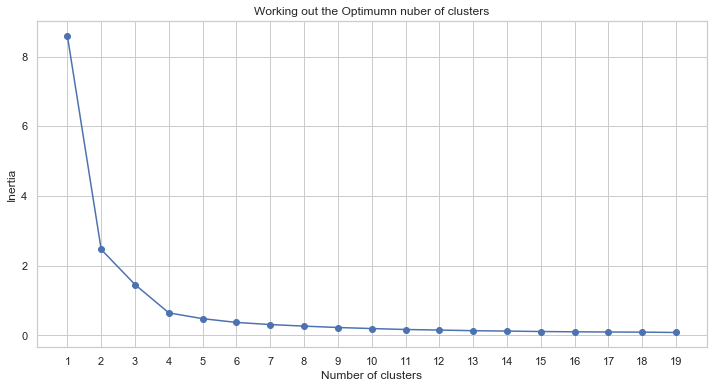

In [224]:
# Working out the best valuse of K (how many clusters)
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++',max_iter = 300, n_init = 10, random_state=2021)
    kmeans.fit(LondonCheckinsClf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xticks(np.arange(min(frame['Cluster']), max(frame['Cluster'])+1, 1.0))
plt.title("Working out the Optimumn nuber of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [225]:
# k=5 is where the elbow is in inertia where increasing the number of clusters won't change much

In [226]:
kmeans = KMeans(n_clusters=5, init='k-means++',max_iter = 300, n_init = 10, random_state=2021)
nonprivate_kmeans = kmeans.fit_predict(LondonCheckinsClf)
c = Counter(kmeans.labels_)
print(c.items())

dict_items([(3, 347), (2, 494), (1, 221), (4, 204), (0, 247)])


homogeneity: each cluster contains only members of a single class.
completeness: all members of a given class are assigned to the same cluster.

In [227]:
from sklearn.metrics.cluster import completeness_score
from sklearn import metrics

metrics.homogeneity_score(nonprivate_kmeans,  kmeans.labels_)

1.0

In [228]:
metrics.completeness_score(nonprivate_kmeans,  kmeans.labels_)

1.0

Perfect labeling!!

In [229]:
#silhouette
scores = silhouette_samples(LondonCheckinsClf, kmeans.labels_)

LondonCheckinsClf["kMeansLabels"] = kmeans.labels_
LondonCheckinsClf["silhouetteScores"] = scores

LondonCheckinsClf = LondonCheckinsClf.sort_values("silhouetteScores")
c.items()

dict_items([(3, 347), (2, 494), (1, 221), (4, 204), (0, 247)])

# Silhouette Scores for Non-Private Clusters

In [230]:
LondonCheckinsClf_Silhouette =  LondonCheckinsClf.filter(["latitude","longitude"], axis=1) 
LondonCheckinsClf_Silhouette.head(1)

,latitude,longitude
451,51.421747,-0.064603


Automatically created module for IPython interactive environment
For n_clusters = 5 The average silhouette_score is : 0.631985634057521


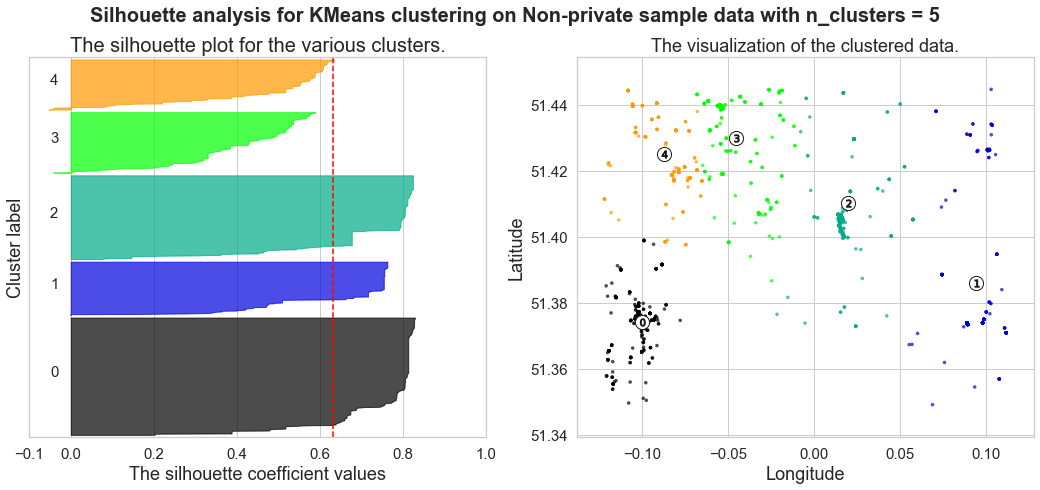

In [231]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=1513,
                  n_features=2,
                  centers=5,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#cluster_labels = clusterer.fit_predict(X)
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++',max_iter = 300, n_init = 10, random_state=2021)
    cluster_labels = clusterer.fit_predict(LondonCheckinsClf_Silhouette)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    #silhouette_avg = silhouette_score(X, c)
    silhouette_avg = silhouette_score(LondonCheckinsClf_Silhouette, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(LondonCheckinsClf_Silhouette, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),fontsize = 15)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize =20)
    ax1.set_xlabel("The silhouette coefficient values", fontsize =18)
    ax1.set_ylabel("Cluster label", fontsize =18)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis="x", labelsize=15)
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(LondonCheckinsClf_Silhouette["longitude"], 
                LondonCheckinsClf_Silhouette["latitude"], marker='.', s=50, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=55, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.", fontsize =18)
    ax2.set_xlabel("Longitude", fontsize =18)
    ax2.set_ylabel("Latitude", fontsize =18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.suptitle(("Silhouette analysis for KMeans clustering on Non-private sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=20, fontweight='bold')

plt.show()

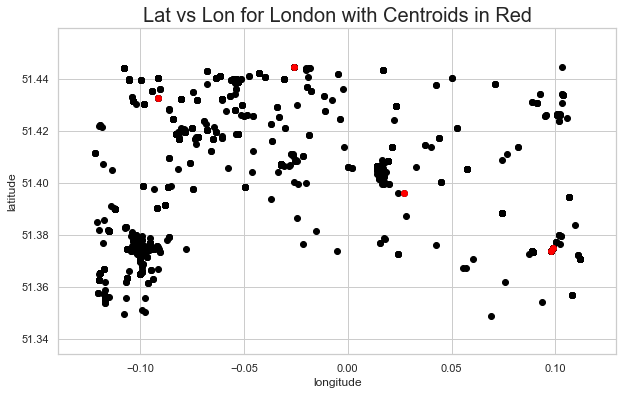

In [232]:
X = LondonCheckinsClf[["longitude","latitude"]]
K=5
# Select random observation as centroids
Centroids = (X.sample(n=K))
plt.figure(figsize=(10,6))
plt.title("Lat vs Lon for London with Centroids in Red",fontsize = 20)
plt.scatter(X["longitude"],X["latitude"],c='black')
plt.scatter(Centroids["longitude"],Centroids["latitude"],c='red')
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.show()

In [233]:
# Assign all the points to the closest cluster centroid & Recompute centroids of newly formed clusters
diff = 1
j=0

while(diff!=0):
    XD=X
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["latitude"]-row_d["latitude"])**2
            d2=(row_c["longitude"]-row_d["longitude"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        X[i]=ED
        i=i+1

    C=[]
    for index,row in X.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    X["kMeansLabels"]=C
    Centroids_new = X.groupby(["kMeansLabels"]).mean()[["longitude","latitude"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['longitude'] - Centroids['longitude']).sum() + (Centroids_new['latitude'] - Centroids['latitude']).sum()
        print(diff.sum())
    Centroids = X.groupby(["kMeansLabels"]).mean()[["longitude","latitude"]]
    #https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

0.0050165325615689725
-0.010666839574608757
-0.015040155954338417
-0.004287370765316524
-0.0012481587973556252
-0.0003116768223538416
-0.00031106270746208975
-0.0004688224469860808
-0.0001669381560971961
0.0


In [234]:
LondonCheckinsClf.head()

,latitude,longitude,kMeansLabels,silhouetteScores
451,51.421747,-0.064603,0,-0.061053
1102,51.399064,-0.085001,4,-0.049344
1072,51.407406,-0.117828,4,-0.028070
193,51.443237,-0.067867,4,-0.014377
215,51.443237,-0.067867,4,-0.014377


In [235]:
LondonCheckinsClf.shape

(1513, 4)

In [236]:
LondonCheckinsClf.kMeansLabels.unique()

array([0, 4, 1, 3, 2])

In [237]:
ClusterColours = {0: 'purple', 1 : 'orange', 2 :'green',3 :'orange',4 :'grey',5 :'cyan',6 :'pink',7 :'yellow'}
LondonCheckinsClf['ClusterColour'] = LondonCheckinsClf.kMeansLabels.map(ClusterColours)
LondonCheckinsClf['ClusterSize'] = 0.1
LondonCheckinsClf

,latitude,longitude,kMeansLabels,silhouetteScores,ClusterColour,ClusterSize
451,51.421747,-0.064603,0,-0.061053,purple,0.1
1102,51.399064,-0.085001,4,-0.049344,grey,0.1
1072,51.407406,-0.117828,4,-0.028070,grey,0.1
193,51.443237,-0.067867,4,-0.014377,grey,0.1
215,51.443237,-0.067867,4,-0.014377,grey,0.1
...,...,...,...,...,...,...
263,51.373896,-0.098976,2,0.827824,green,0.1
525,51.373896,-0.098976,2,0.827824,green,0.1
1319,51.374292,-0.097018,2,0.827860,green,0.1
1479,51.373878,-0.098541,2,0.828288,green,0.1


In [238]:
#plot the user points and add train stations as recommender locations
fig = px.scatter_mapbox(LondonCheckinsClf, lat="latitude", lon="longitude", hover_name="kMeansLabels", 
                        color="kMeansLabels",size ="ClusterSize", zoom=10,  width=1000, height=600)


#add the train stations
fig.add_trace(px.scatter_mapbox(LondonStations, lat="Latitude", lon="Longitude", hover_name="Station",
                                color_discrete_sequence=["black"],size_max=30, zoom=10, width=1000, height=600).data[0])

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

# Now apply Diferential Privacy K-Means Clustering

In [239]:
#libraries
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_samples
%matplotlib inline
import os
from sklearn.metrics import confusion_matrix

##the IBM diff privacy KMeans model
from diffprivlib.models import KMeans as DPKMeans

## Cit https://diffprivlib.readthedocs.io/en/latest/modules/models.html#clustering-models

In [240]:
# removing columns that don't add to ML & privacy for DIFF PRIV K MEANS
LondonCheckinsClfPRIV = LondonCheckinsClf.drop(['silhouetteScores','ClusterColour','ClusterSize','kMeansLabels'], axis=1)
LondonCheckinsClfPRIV.head()

,latitude,longitude
451,51.421747,-0.064603
1102,51.399064,-0.085001
1072,51.407406,-0.117828
193,51.443237,-0.067867
215,51.443237,-0.067867



Cit https://diffprivlib.readthedocs.io/en/latest/modules/models.html#clustering-models

epsilon (float, default: 0.2) – Privacy parameter ϵ.

bounds (tuple, optional) – Bounds of the data, provided as a tuple of the form (min, max). min and max can either be scalars, covering the min/max of the entire data, or vectors with one entry per feature. If not provided, the bounds are computed on the data when .fit() is first called, resulting in a PrivacyLeakWarning.

n_clusters (int, 3) – The number of clusters to form as well as the number of centroids to generate.

accountant (BudgetAccountant, optional) – Accountant to keep track of privacy budget.(

Text(0, 0.5, 'Inertia')

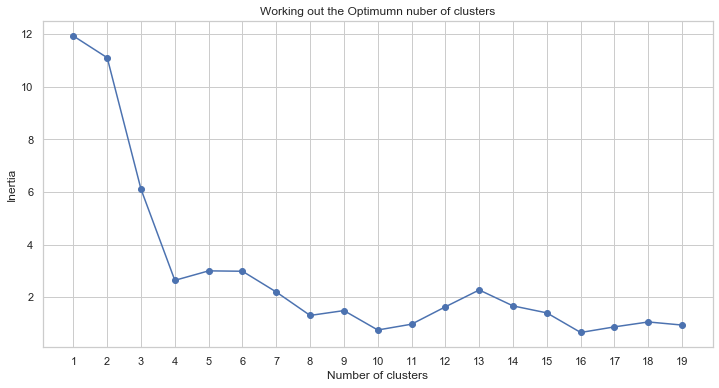

In [241]:
# Working out the best value of K (how many clusters)
import warnings
warnings.filterwarnings("ignore")

SSE = []
for cluster in range(1,20):
    kmeansPRIV = DPKMeans(n_jobs = -1, n_clusters = cluster, epsilon=0.1 , bounds=None, accountant=None, random_state=2021)
    kmeansPRIV.fit(LondonCheckinsClfPRIV)
    SSE.append(kmeansPRIV.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xticks(np.arange(min(frame['Cluster']), max(frame['Cluster'])+1, 1.0))
plt.title("Working out the Optimumn nuber of clusters")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [242]:
LondonCheckinsClfPRIV.head()

,latitude,longitude
451,51.421747,-0.064603
1102,51.399064,-0.085001
1072,51.407406,-0.117828
193,51.443237,-0.067867
215,51.443237,-0.067867


In [243]:
K=5
kmeansP = DPKMeans(n_clusters = K, epsilon=0.1 , bounds=None, accountant=None, random_state=2021)
DPKmeans = kmeansP.fit(LondonCheckinsClfPRIV)
cdp = Counter(kmeansP.labels_)
print(cdp.items())

#nonprivate dict_items([(3, 151), (2, 654), (1, 202), (4, 86), (0, 404)])
#or
# epsilon=float("inf") dict_items([(0, 404), (2, 151), (3, 202), (1, 86), (4, 654)]) -same as non-private check

# epsilon=1 dict_items([(2, 569), (1, 276), (4, 192), (0, 22), (3, 438)])
# epsilon=.8 dict_items([(2, 675), (3, 202), (0, 252), (1, 335), (4, 33)])
# epsilon=.5 dict_items([(2, 720), (3, 490), (0, 6), (4, 201), (1, 80)])
# epsilon=.3 dict_items([(3, 709), (0, 181), (4, 273), (1, 328), (2, 6)])
# epsilon=.2 dict_items([(4, 1158), (2, 37), (3, 218), (0, 49), (1, 35)])
# epsilon=.1 dict_items([(3, 106), (0, 790), (2, 175), (4, 349), (1, 77)])

dict_items([(2, 942), (4, 43), (3, 339), (0, 15), (1, 174)])


In [244]:
#silhouette
DPscores = silhouette_samples(LondonCheckinsClfPRIV, kmeansP.labels_)

LondonCheckinsClfPRIV["DPkMeansLabels"] = kmeansP.labels_
LondonCheckinsClfPRIV["DPsilhouetteScores"] = DPscores

LondonCheckinsClfPRIV = LondonCheckinsClfPRIV.sort_values("DPsilhouetteScores")
cdp.items()

dict_items([(2, 942), (4, 43), (3, 339), (0, 15), (1, 174)])

In [245]:
LondonCheckinsClfPRIV.DPkMeansLabels.unique()

array([2, 1, 0, 3, 4], dtype=int64)

# Silhouette Scores after applying DP

In [246]:
LondonCheckinsClfPRIV_Silhouette =  LondonCheckinsClfPRIV.filter(["latitude","longitude"], axis=1) 
LondonCheckinsClfPRIV_Silhouette.head(1)

,latitude,longitude
1060,51.4185,-0.018666


Automatically created module for IPython interactive environment
For n_clusters = 5 The average silhouette_score is : 0.3895410328331353


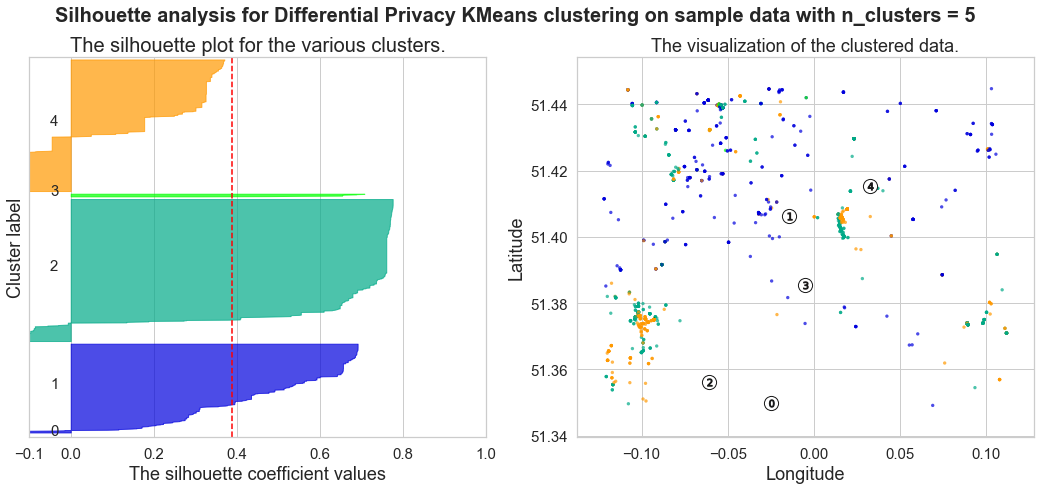

In [247]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=1513,
                  n_features=2,
                  centers=5,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #cluster_labels = clusterer.fit_predict(X)

    clusterer = DPKMeans(n_clusters = n_clusters, epsilon=0.1 , bounds=None, accountant=None, random_state=2021)
    cluster_labels = clusterer.fit_predict(LondonCheckinsClfPRIV_Silhouette)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    #silhouette_avg = silhouette_score(X, c)
    silhouette_avg = silhouette_score(LondonCheckinsClfPRIV_Silhouette, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(LondonCheckinsClfPRIV_Silhouette, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i),fontsize = 15)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize =20)
    ax1.set_xlabel("The silhouette coefficient values", fontsize =18)
    ax1.set_ylabel("Cluster label", fontsize =18)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis="x", labelsize=15)
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(LondonCheckinsClf_Silhouette["longitude"], 
                LondonCheckinsClf_Silhouette["latitude"], marker='.', s=45, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 1], centers[:, 0], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[1], c[0], marker='$%d$' % i, alpha=1,
                    s=55, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.", fontsize =18)
    ax2.set_xlabel("Longitude", fontsize =18)
    ax2.set_ylabel("Latitude", fontsize =18)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.suptitle(("Silhouette analysis for Differential Privacy KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=20, fontweight='bold')

plt.show()

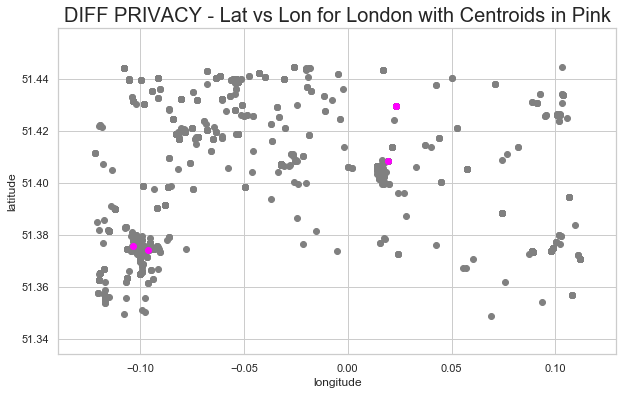

In [248]:
Z = LondonCheckinsClfPRIV[["longitude","latitude"]]
K=5
# Select random observation as centroids
DPCentroids = (Z.sample(n=K))
plt.figure(figsize=(10,6))
plt.title("DIFF PRIVACY - Lat vs Lon for London with Centroids in Pink",fontsize = 20)
plt.scatter(Z["longitude"],Z["latitude"],c='grey')
plt.scatter(DPCentroids["longitude"],DPCentroids["latitude"],c='fuchsia')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

In [249]:
# Assign all the points to the closest cluster centroid & Recompute centroids of newly formed clusters
diff = 1
j=0

while(diff!=0):
    XD=Z
    i=1
    for index1,row_c in DPCentroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["latitude"]-row_d["latitude"])**2
            d2=(row_c["longitude"]-row_d["longitude"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        Z[i]=ED
        i=i+1

    C=[]
    for index,row in Z.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    Z["DPkMeansLabels"]=C
    DPCentroids_new = Z.groupby(["DPkMeansLabels"]).mean()[["longitude","latitude"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (DPCentroids_new['longitude'] - DPCentroids['longitude']).sum() + (DPCentroids_new['latitude'] - DPCentroids['latitude']).sum()
        print(diff.sum())
    DPCentroids = Z.groupby(["DPkMeansLabels"]).mean()[["longitude","latitude"]]
    #https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

0.20099946999233595
0.005469419523247251
-0.002687144524027144
-0.013269103228128593
-0.008537203244276596
-0.0010412349266746626
-0.003018302527185296
-0.0009479142294496513
0.0


In [251]:
LondonCheckinsClfPRIV.head()

,latitude,longitude,DPkMeansLabels,DPsilhouetteScores
1060,51.418500,-0.018666,2,-0.434132
456,51.418500,-0.018666,2,-0.434132
1279,51.418500,-0.018666,2,-0.434132
964,51.414074,0.082006,1,-0.429295
970,51.414074,0.082006,1,-0.429295


In [252]:
LondonCheckinsClfPRIV.DPkMeansLabels.unique()

array([2, 1, 0, 3, 4], dtype=int64)

In [253]:
ClusterColours1 = {0: 'purple', 1 : 'orange', 2 :'green',3 :'orange',4 :'grey',5 :'cyan',6 :'pink',7 :'yellow'}
LondonCheckinsClfPRIV['ClusterColour'] = LondonCheckinsClfPRIV.DPkMeansLabels.map(ClusterColours1)
LondonCheckinsClfPRIV['ClusterSize'] = .2
LondonCheckinsClfPRIV

,latitude,longitude,DPkMeansLabels,DPsilhouetteScores,ClusterColour,ClusterSize
1060,51.418500,-0.018666,2,-0.434132,green,0.2
456,51.418500,-0.018666,2,-0.434132,green,0.2
1279,51.418500,-0.018666,2,-0.434132,green,0.2
964,51.414074,0.082006,1,-0.429295,orange,0.2
970,51.414074,0.082006,1,-0.429295,orange,0.2
...,...,...,...,...,...,...
1259,51.426413,0.100919,4,0.844407,grey,0.2
1273,51.426413,0.100919,4,0.844407,grey,0.2
1258,51.426413,0.100919,4,0.844407,grey,0.2
25,51.426544,0.100761,4,0.845223,grey,0.2


In [254]:
#plot the user points and add train stations as recommender locations
fig = px.scatter_mapbox(LondonCheckinsClfPRIV, lat="latitude", lon="longitude", hover_name="DPkMeansLabels", 
                       color="DPkMeansLabels",size ='ClusterSize', zoom=10, width=1000, height=600)

#add the train stations
fig.add_trace(px.scatter_mapbox(LondonStations, lat="Latitude", lon="Longitude", hover_name="Station", 
                        color_discrete_sequence=["black"],size_max=30, zoom=10, width=1000, height=600).data[0])
 
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

In [255]:
LondonCheckinsClfPRIV.ClusterColour.unique()

array(['green', 'orange', 'purple', 'grey'], dtype=object)